In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.stats import sandwich_covariance
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simpleRegression(input_dataframe, regressor_column, regressee_column):
    mod = sm.OLS(input_dataframe[regressee_column], sm.add_constant(input_dataframe[regressor_column]))
    res = mod.fit()
    return res

def rollingWindowRegression(window_size, input_dataframe, regressor_column, regressee_column, index_column):
    df_rolling_window = pd.DataFrame(columns=[index_column, 'coef', 'se', 't', 'y_actual', 'y_pred'])

    for i in range(window_size, len(input_dataframe)):
        input_dataframe_window = input_dataframe[[regressee_column, regressor_column]][i-window_size:i]

        mod_rolling_window = sm.OLS(input_dataframe_window[regressee_column], sm.add_constant(input_dataframe_window[regressor_column]))
        res_rolling_window = mod_rolling_window.fit()

        beta0, beta1 = res_rolling_window.params
        beta1_se = res_rolling_window.bse[1]
        beta1_tvalue = res_rolling_window.tvalues[1] 

        y_actual = input_dataframe[regressee_column][i]
        y_pred = beta0 + input_dataframe[regressor_column][i] * beta1

        df_rolling_window.loc[i - window_size] = [input_dataframe[index_column][i], beta1, beta1_se, beta1_tvalue, y_actual, y_pred] # start from row 31

    df_rolling_window['upper'] = df_rolling_window['coef'] + df_rolling_window['se']
    df_rolling_window['lower'] = df_rolling_window['coef'] - df_rolling_window['se']
    df_rolling_window['y_error'] = df_rolling_window['y_pred'] - df_rolling_window['y_actual']

    return df_rolling_window

In [3]:
df_gp = pd.read_csv("/Users/Lena.H/Desktop/HKU-MFin/MFIN7037-Quant-trading/qtwd/homework2_data.csv")

# task 1
df_gp['gp_ratio'] = df_gp['gold_last_month']/df_gp['plat_last_month']
df_gp['log_gp_ratio'] = np.log(df_gp['gold_last_month']/df_gp['plat_last_month'])

df_gp['trading_dt'] = pd.to_datetime(df_gp['trading_dt'])
df_gp = df_gp.set_index('trading_dt')
df_gp['gp_original_dt'] = df_gp.index.shift(-1, freq='M')
df_gp.reset_index(inplace=True) # convert trading_dt back to column

df_gp_gpratio_vix = df_gp[['gp_ratio', 'vix']].dropna()

# Note: sp.stats.skew corresponds with type 1 & 2 in R (R skew default type 3)
# so the results are different from in R
print('gp_ratio mean: ', np.mean(df_gp['gp_ratio']), '\n',
      'gp_ratio sd: ', np.std(df_gp['gp_ratio'], ddof=1), '\n',
      'gp_ratio skewness: ', skew(df_gp['gp_ratio']), '\n', # equivalent to R skewness type 1 
      'log_gp_ratio mean: ', np.mean(df_gp['log_gp_ratio']), '\n',
      'log_gp_ratio sd: ', np.std(df_gp['log_gp_ratio'], ddof=1), '\n',
      'log_gp_ratio skewness: ', skew(df_gp['log_gp_ratio']), '\n',
      'corr(gp_ratio, VIX): ', np.corrcoef(df_gp_gpratio_vix['gp_ratio'], df_gp_gpratio_vix['vix'])[0][1])


gp_ratio mean:  0.7998900067381806 
 gp_ratio sd:  0.2533461356757065 
 gp_ratio skewness:  -0.2105317286396528 
 log_gp_ratio mean:  -0.2863174739894789 
 log_gp_ratio sd:  0.38343906739439026 
 log_gp_ratio skewness:  -1.2757213331756694 
 corr(gp_ratio, VIX):  -0.039909246351623746


In [4]:
# ref: hardcode on 3 types of R skewness
gp_ratio_skew1 = ((df_gp['gp_ratio']-np.mean(df_gp['gp_ratio'])) ** 3).sum()/df_gp['gp_ratio'].count()/((((df_gp['gp_ratio']-np.mean(df_gp['gp_ratio'])) ** 2).sum()/df_gp['gp_ratio'].count()) ** 1.5)
gp_ratio_skew2 = gp_ratio_skew1 * (df_gp['gp_ratio'].count() * (df_gp['gp_ratio'].count() - 1)) ** 0.5/(df_gp['gp_ratio'].count() - 2)
gp_ratio_skew3 = gp_ratio_skew1 * ((df_gp['gp_ratio'].count() - 1)/df_gp['gp_ratio'].count()) ** 1.5

gp_ratio_skew1, gp_ratio_skew2, gp_ratio_skew3

(-0.2105317286396527, -0.21106963813723723, -0.20999579737431937)

Text(0,0.5,'log_gp_ratio')

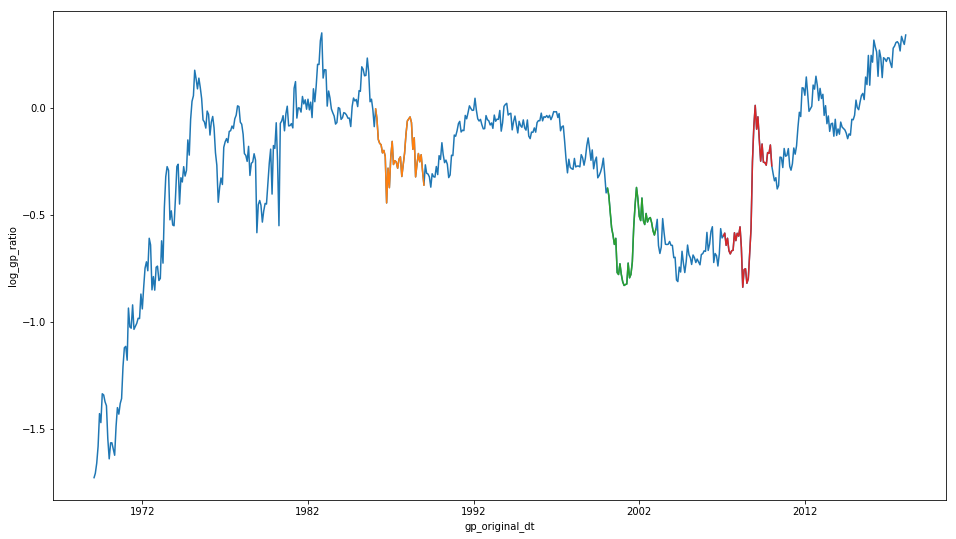

In [5]:
# task 2

plt.figure(figsize=(16,9))

df_gp1 = df_gp[((pd.to_datetime(df_gp['gp_original_dt'])).dt.year >= 1986) & ((pd.to_datetime(df_gp['gp_original_dt'])).dt.year <=1988)] # 1987 stock market crash
df_gp2 = df_gp[((pd.to_datetime(df_gp['gp_original_dt'])).dt.year >= 2000) & ((pd.to_datetime(df_gp['gp_original_dt'])).dt.year <=2002)] # Internet Bubble in US
df_gp3 = df_gp[((pd.to_datetime(df_gp['gp_original_dt'])).dt.year >= 2007) & ((pd.to_datetime(df_gp['gp_original_dt'])).dt.year <=2009)] # Financial crisis

plt.plot(pd.to_datetime(df_gp['gp_original_dt']), df_gp['log_gp_ratio'])
plt.plot(pd.to_datetime(df_gp1['gp_original_dt']), df_gp1['log_gp_ratio'])
plt.plot(pd.to_datetime(df_gp2['gp_original_dt']), df_gp2['log_gp_ratio'])
plt.plot(pd.to_datetime(df_gp3['gp_original_dt']), df_gp3['log_gp_ratio'])
plt.xlabel('gp_original_dt')
plt.ylabel('log_gp_ratio') 

In [6]:
# task 3  
res = simpleRegression(df_gp, 'log_gp_ratio', 'mkt_rf')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 mkt_rf   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.21
Date:                Fri, 08 Jun 2018   Prob (F-statistic):           0.000866
Time:                        10:14:57   Log-Likelihood:                 994.01
No. Observations:                 589   AIC:                            -1984.
Df Residuals:                     587   BIC:                            -1975.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0098      0.002      4.244   

In [7]:
# task 4
df_gp4 = df_gp[(pd.to_datetime(df_gp['trading_dt'])).dt.year < 1990] 
df_gp5 = df_gp[(pd.to_datetime(df_gp['trading_dt'])).dt.year >= 1990] 

mod_before_1990 = sm.OLS(df_gp4['mkt_rf'], sm.add_constant(df_gp4['log_gp_ratio']))
res_before_1990 = mod_before_1990.fit()

mod_after_1990 = sm.OLS(df_gp5['mkt_rf'], sm.add_constant(df_gp5['log_gp_ratio']))
res_after_1990 = mod_after_1990.fit()

print(res_before_1990.summary(), res_after_1990.summary())

                            OLS Regression Results                            
Dep. Variable:                 mkt_rf   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.636
Date:                Fri, 08 Jun 2018   Prob (F-statistic):             0.0577
Time:                        10:14:57   Log-Likelihood:                 403.97
No. Observations:                 251   AIC:                            -803.9
Df Residuals:                     249   BIC:                            -796.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0075      0.004      1.970   

In [8]:
# Newey-West
res_nw = sm.OLS(df_gp['mkt_rf'], sm.add_constant(df_gp['log_gp_ratio'])).fit(cov_type='HAC',cov_kwds={'maxlags':3}, use_t=True)
res_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 mkt_rf   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.33
Date:                Fri, 08 Jun 2018   Prob (F-statistic):           0.000811
Time:                        10:14:57   Log-Likelihood:                 994.01
No. Observations:                 589   AIC:                            -1984.
Df Residuals:                     587   BIC:                            -1975.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0098      0.002      4.535      0.000       0.006       0.014
log_gp_ratio     0.0161      0.005      3.366      0.001       0.007       0.026
==============================================================================
Omnibus:                       51.853   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.564
Skew:                          -0.517   Prob(JB):                     2.67e-24
Kurtosis:                       4.831   Cond. No.                         2.86
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

OOS_r_square:  -0.10919300855060743


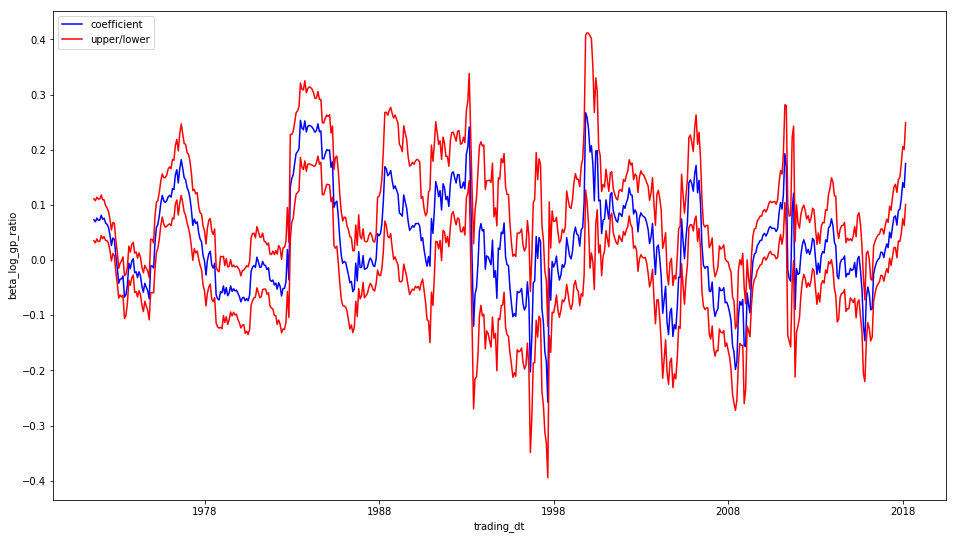

In [9]:
# rolling window
loggp_mkt_rf_rolling_window_30 = rollingWindowRegression(30, df_gp, 'log_gp_ratio', 'mkt_rf', 'trading_dt')

# plot coefficient & error band
plt.figure(figsize=(16,9))
plt.plot(loggp_mkt_rf_rolling_window_30['trading_dt'], loggp_mkt_rf_rolling_window_30['coef'], color='b')
plt.plot(loggp_mkt_rf_rolling_window_30['trading_dt'], loggp_mkt_rf_rolling_window_30['upper'], color='r')
plt.plot(loggp_mkt_rf_rolling_window_30['trading_dt'], loggp_mkt_rf_rolling_window_30['lower'], color='r')
plt.legend(['coefficient', 'upper/lower'], loc='upper left')
plt.xlabel('trading_dt')
plt.ylabel('beta_log_gp_ratio') 

# OOS performance
SSE = (loggp_mkt_rf_rolling_window_30['y_error'] ** 2).sum()
SST = ((loggp_mkt_rf_rolling_window_30['y_actual'] - np.mean(loggp_mkt_rf_rolling_window_30['y_actual'])) ** 2).sum()
OOS_r_square = 1 - SSE/SST
print('OOS_r_square: ', OOS_r_square)

# 1987 & 2009


In [10]:
# Fama-French 25 portfolios
# searched in excel that no value is marked as -99.99 or -999 => no missing value
df_fm25_vw = pd.read_csv("/Users/Lena.H/Desktop/HKU-MFin/MFIN7037-Quant-trading/qtwd/25_Portfolios_5x5-Average-Value-Weighted-Returns-monthly.csv")
df_fm25_vw = df_fm25_vw.rename(columns = {'Unnamed: 0':'trading_dt'})

df_fm25_vw['trading_dt'] = df_fm25_vw['trading_dt'].apply(lambda x: pd.to_datetime(str(x)[:4] + '-' + str(x)[-2:]))

df_fm25_vw = df_fm25_vw.set_index('trading_dt')
df_fm25_vw.index = df_fm25_vw.index.shift(-1, freq='M')
df_fm25_vw.index = df_fm25_vw.index.shift(1, freq='M')
df_fm25_vw.reset_index(inplace=True)

df_loggp_fm25 = pd.merge(df_fm25_vw, df_gp[['trading_dt', 'log_gp_ratio']], how='inner', on='trading_dt')
df_loggp_fm25.dropna(inplace=True) # no NA in original file
df_loggp_fm25.head()

,trading_dt,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,...,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM,log_gp_ratio
0,1969-02-28,-12.3778,-10.7260,-9.0526,-8.6709,-8.7759,-11.0517,-8.1595,-4.9194,-7.1111,...,-7.4832,-4.9699,-7.2058,-8.7325,-3.3489,-3.1052,-5.0873,-4.6013,-6.2234,-1.725593
1,1969-03-31,3.1292,2.4655,3.5593,4.1551,2.3585,4.2281,1.6875,2.1416,0.3812,...,-2.0836,2.4841,1.6877,3.5591,4.2210,2.8972,3.7085,1.9452,4.9125,-1.705226
2,1969-04-30,1.0512,-0.4918,0.9962,2.4926,0.0236,1.5504,1.1246,1.0608,-0.5481,...,2.3272,0.4506,-0.5986,1.7164,3.7241,1.1637,0.8682,3.0219,0.8245,-1.657576
3,1969-05-31,1.0264,0.8101,1.0107,0.7894,0.4709,-1.9559,-1.6136,-0.9643,0.0683,...,-0.7197,1.2997,1.1946,-2.4691,-0.4876,0.5525,0.9661,1.4482,0.6341,-1.579070
4,1969-06-30,-14.6433,-12.9202,-13.4579,-12.5925,-12.2861,-12.1776,-11.0698,-9.1469,-10.0546,...,-8.8078,-7.2027,-8.5142,-8.4162,-1.5913,-6.8220,-7.4524,-6.6619,-8.4542,-1.426633


In [11]:
regressees = list(df_loggp_fm25)[1:-1]

ari_avg_returns = np.zeros(len(regressees))
geo_avg_returns = np.zeros(len(regressees))
betas = np.zeros(len(regressees))

for i in range(len(regressees)):
    res = simpleRegression(df_loggp_fm25, 'log_gp_ratio', regressees[i])
    beta = res.params[1]
    geo_avg_return = ((df_loggp_fm25[regressees[i]]/100 + 1).cumprod().iloc[-1]) ** (1 / len(df_loggp_fm25)) - 1
    ari_avg_return = np.mean(df_loggp_fm25[regressees[i]])
    betas[i] = beta
    geo_avg_returns[i] = geo_avg_return * 100
    ari_avg_returns[i] = ari_avg_return * 100


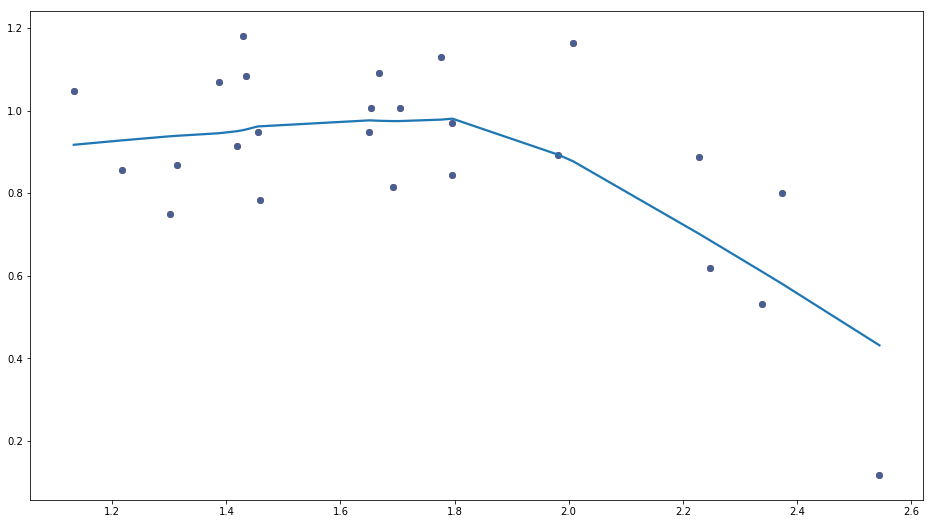

In [12]:
# plot in geometric average return
plt.figure(figsize = (16,9))
plt.scatter(betas, geo_avg_returns, color='r')
sns.regplot(betas, geo_avg_returns, lowess=True)

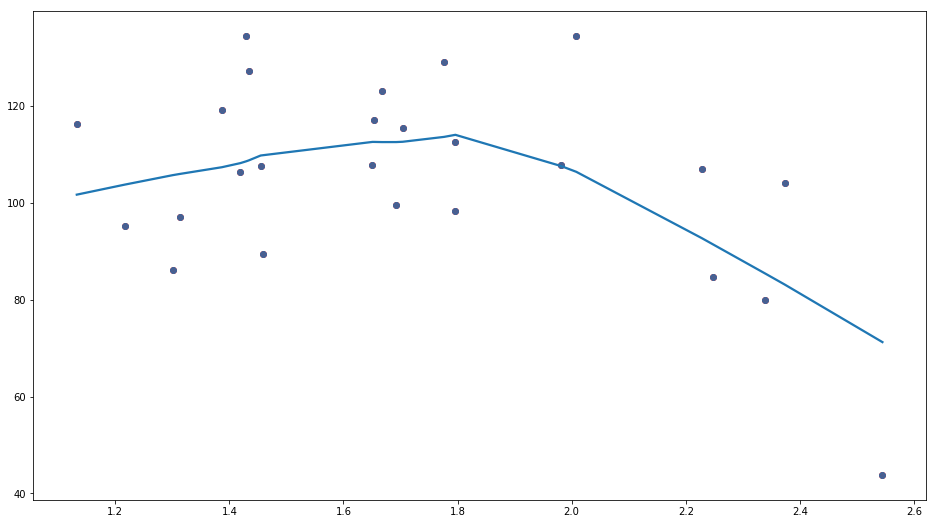

In [13]:
# plot in arithmetic average return
plt.figure(figsize = (16,9))
plt.scatter(betas, ari_avg_returns, color='r')
sns.regplot(betas, ari_avg_returns, lowess=True)